In [88]:
using Optim
using LinearAlgebra
using ProgressMeter
using StatsBase
using Plots
using FisherGillespie

In [89]:
# Model: single qubit with Rabi oscillations, coupled with a thermal bath.
# System parameters.
γ_true = 0.4
nth = 1.
ΩA = 1.
ΩB = 1.
g = 0.01

# Simulation parameters.
dt = 0.001
dγ = 0.0001
t_final = 200.
number_trajectories = 5

t_range = 0:dt:t_final

# Auxiliary operators.
σm = complex([0 1; 0 0])
σp = σm';
σx = complex([0 1; 1 0])
ide = complex([1 0; 0 1])

# Hamiltonian.
H = ΩA * kron(σx, ide) + ΩB * kron(ide, σx) + g * (kron(σp, σm) + kron(σm, σp))
Hp = H
Hm = H

# Jump operators.
L_in = sqrt(γ_true * nth) * kron(σp, ide)

# Displaced jump operators.
Lp_in = sqrt((γ_true + dγ) * nth) * kron(σp, ide)
Lm_in = sqrt((γ_true - dγ) * nth) * kron(σp, ide)

# Jump operators list.
M_l = [L_in]
Mp_l = [Lp_in]
Mm_l = [Lm_in]

# Initial state.
ψ0 = kron(complex([1. ; 0.]), complex([1., 0.]))

4-element Vector{ComplexF64}:
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [90]:
trajectories_results, V, Vdot, t_range = FisherGillespie.gillespie_fisher(H, Hp, Hm, M_l, Mp_l, Mm_l, dγ, ψ0, t_final, dt, number_trajectories);

Fisher-Gillespie evolution... 100%|██████████████████████| Time: 0:00:12


-> Truncation error given by norm of latest Qs matrix: 2.5022711698272534e-18


In [91]:
single_trajectory = trajectories_results[1];

In [92]:
# Auxiliary functions: allow for an evaluation of H and derivative, and M_l and derivative at any θ.
f_H_θ(γ) = H
f_M_l_θ(γ) = [sqrt(γ * nth) * kron(σp, ide)]

f_M_l_θ (generic function with 1 method)

In [93]:
# Cost function, given a value of θ.
cost_function(γ) = real(tr(FisherGillespie.evolve_ξ_on_trajectory(γ[1], single_trajectory, f_H_θ, f_M_l_θ, ψ0, t_final, dt, dγ)))^2

cost_function (generic function with 1 method)

# Single trajectory studies

In [94]:
γ0 = [0.15]
lower_γ = [0.]
upper_γ = [1.]
results = optimize(cost_function, lower_γ, upper_γ, γ0)

 * Status: success

 * Candidate solution
    Final objective value:     2.997686e-16

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 4.28e-13 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.62e-13 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.87e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    5
    f(x) calls:    232
    ∇f(x) calls:   232


In [95]:
results.minimizer

1-element Vector{Float64}:
 0.44486488303582317

# Multiple trajectories study

In [96]:
number_trajectories = 500
trajectories_results, V, Vdot, t_range = FisherGillespie.gillespie_fisher(H, Hp, Hm, M_l, Mp_l, Mm_l, dγ, ψ0, t_final, dt, number_trajectories);

Fisher-Gillespie evolution... 100%|██████████████████████| Time: 0:18:05


-> Truncation error given by norm of latest Qs matrix: 2.5022711698272534e-18


In [97]:
v_mle = []

# Fix initial value and boundaries for optimisation.
γ0 = [0.15]
lower_γ = [0.1]
upper_γ = [1.]

@showprogress "Estimating" for trajectory in 1:number_trajectories
    single_trajectory = trajectories_results[trajectory]
    results = optimize(cost_function, lower_γ, upper_γ, γ0)
    est_value = results.minimizer[1]
    push!(v_mle, est_value)
end

Estimating 100%|█████████████████████████████████████████| Time: 0:11:02


In [98]:
v_mle

500-element Vector{Any}:
 0.43895982086378715
 0.3741854339145802
 0.46725452733518946
 0.42394482741107736
 0.29322948047165925
 0.4260526070206904
 0.48946721576934
 0.35619248969321654
 0.48069523609525905
 0.4169201700714205
 0.44342681616014057
 0.322995641399768
 0.3265194059343357
 ⋮
 0.2351682606907383
 0.3048910999607697
 0.5403276696310207
 0.4525942259000729
 0.4232730754058084
 0.36703783877922663
 0.38869648852036226
 0.3505654780227553
 0.46156848513424664
 0.5200204663776297
 0.3864197024205016
 0.45143112965542176

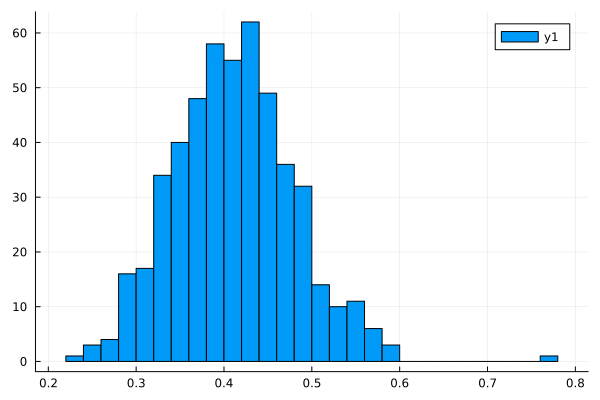

In [99]:
histogram(v_mle, bins=30)
# savefig("Histogram_MLE.png")

In [100]:
average_fisher = zeros(length(t_range))
println()

@showprogress 1 "Filling in the gaps..." for n_trajectory in eachindex(trajectories_results)
    v_fisher = FisherGillespie.fisher_at_time_on_trajectory(t_range, t_range, V, Vdot, trajectories_results[n_trajectory], ψ0)
    average_fisher += v_fisher / number_trajectories
end

Filling in the gaps... 100%|█████████████████████████████| Time: 0:04:35


In [101]:
plot(t_range, average_fisher)

In [102]:
using CurveFit

a, m = linear_fit(t_range, average_fisher)
fi_rate = m

final_FI = fi_rate * last(t_range)

249.43607558014813

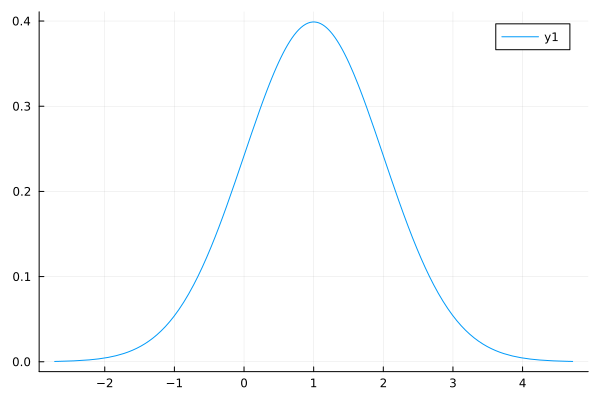

In [103]:
using Distributions
using StatsPlots

Distributions.fit(Normal, float.(v_mle)).σ
plot(Normal(1,1))

In [104]:
sqrt(1/final_FI)

0.06331700553105

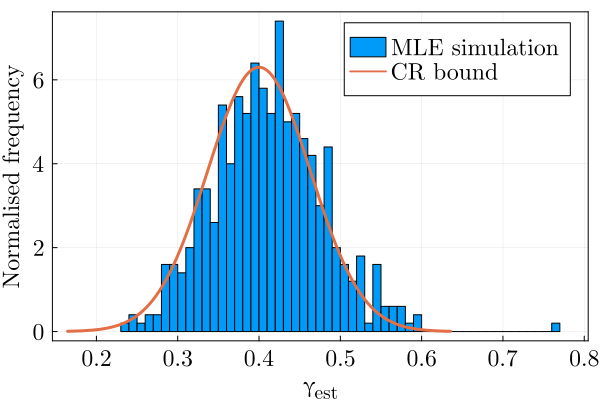

In [105]:
histogram(v_mle, bins=50, normalize=:pdf, label="MLE simulation", xlabel="\\gamma_{est}", ylabel="Normalised frequency", fontfamily="Computer Modern", guidefontsize=15, tickfontsize=15, legendfontsize=15, border=:box)
plot!(Normal(γ_true, 1/sqrt(final_FI)), linewidth=3, label="CR bound")
# savefig("Histogram_CR_2_qubits.pdf")

# Studies as a function of the final time

In [106]:
function truncate_measurement_record_at_final_time(measurement_record, final_time)
    new_measurement_record = Dict{String, Any}[]
    for jump in measurement_record
       if jump["AbsTime"] < final_time
            push!(new_measurement_record, jump)
        end
    end
    
    return new_measurement_record
end

truncate_measurement_record_at_final_time (generic function with 1 method)

In [107]:
t_final_to_explore = 10:10:t_final
γ0 = [0.15]
lower_γ = [0.1]
upper_γ = [1.]

v_sigmas = []

display("Starting to estimate")
@showprogress "Estimating for times..." for specific_t_final in t_final_to_explore
    v_estimates = Float64[]
    for trajectory in 1:number_trajectories
        truncated_trajectory = truncate_measurement_record_at_final_time(trajectories_results[trajectory], specific_t_final)
        cost_function(γ) = real(tr(FisherGillespie.evolve_ξ_on_trajectory(γ[1], truncated_trajectory, f_H_θ, f_M_l_θ, ψ0, specific_t_final, dt, dγ)))^2
        results = optimize(cost_function, lower_γ, upper_γ, γ0)
        est_value = results.minimizer[1]
        push!(v_estimates, est_value)
    end
    push!(v_sigmas, Distributions.fit(Normal, float.(v_estimates)).σ)
    # display(histogram(v_estimates, bins=30, title="T final " * string(specific_t_final)))
end

"Starting to estimate"

Estimating for times... 100%|████████████████████████████| Time: 1:34:11


In [108]:
using LaTeXStrings
plot(t_final_to_explore, v_sigmas, xaxis=:log, yaxis=:log, label="MLE simulation", seriestype=:scatter, xlabel=L"t_{f}", ylabel="MSE", fontfamily="Computer Modern", guidefontsize=15, tickfontsize=15, legendfontsize=15, border=:box)
plot!(t_final_to_explore, 1 ./sqrt.(fi_rate .* t_final_to_explore), label="CR bound")
savefig("CR_Bound_MLE_two_qubits.pdf")